In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
signal = ObjIter(list(map(Tree,fc.eightb.accstudies.raw_with_pu.signal_list)))

# signal_trees.extend(kwargs=lambda tree : dict(n_ext_jet=tree.n_jet-tree.nfound_presel))
# signal_trees.extend(kwargs=eightb.reco_all)
# signal_trees.extend(kwargs=eightb.reco_res_all)

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


In [3]:
def get_point(label):
    label = label.split('_')
    return str((int(label[1]),int(label[3])))
signal_points = list(map(get_point,signal.sample))

In [4]:
dout = "gen_studies/resonances/"

In [5]:
ylist = [
    f'gen_{y}'
    for y in ('Y1','Y2')
]

higgslist = [
    f'gen_{h}{y}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
]


quarklist = [
    f'gen_{h}{y}_{b}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
    for b in ('b1','b2')
]

In [6]:
varinfo.clear()

In [7]:
class YeildInfo:
    def __init__(self):
        self.yields = []

    def __call__(self, trees, event_filter=None, collection_filter=None):
        if collection_filter:
            trees = trees.apply(collection_filter)
        if event_filter:
            trees = trees.apply(event_filter)
        self.yields.append(
            trees.Run.apply(ak.count).npy
        )

        if len(self.yields) > 1:
            print(self.yields[-1]/self.yields[-2])
        return trees
yieldinfo = YeildInfo()

In [8]:
signal = yieldinfo(signal)

In [9]:
trigger_name = "HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5"
trigger = EventFilter('trigger',**{trigger_name:1})

In [10]:
signal = yieldinfo(signal, trigger)

[0.78013328 0.94499426 0.96046341]


In [11]:
muon_veto = EventFilter('muon_veto', filter=lambda t:t.n_muon == 0)

In [12]:
signal = yieldinfo(signal, muon_veto)

[0.97575914 0.9751149  0.97558537]


In [13]:
ele_veto = EventFilter('ele_veto', filter=lambda t:t.n_ele == 0)

In [14]:
signal = yieldinfo(signal, ele_veto)

[0.97689663 0.97820573 0.97875412]


In [15]:
f_j8_pt20 = CollectionFilter('jet', filter=lambda t:t.jet_pt>20)
j8_pt20 = EventFilter('j8_pt20', filter=lambda t: ak.count(t.jet_pt,axis=-1) >= 8)

In [16]:
signal = yieldinfo(signal, j8_pt20, f_j8_pt20)

[0.85944067 0.89801982 0.91678582]


In [17]:
f_j8_eta25 = CollectionFilter('jet', filter=lambda t: np.abs(t.jet_eta) < 2.5)
j8_eta25 = EventFilter('j8_eta25', filter=lambda t: ak.count(t.jet_pt,axis=-1) >= 8)

In [18]:
signal = yieldinfo(signal, j8_eta25, f_j8_eta25)

[0.82513054 0.85490897 0.87417105]


In [19]:
f_j8_id = CollectionFilter('jet', filter=lambda t: ((t.jet_id>>1)&1)==1)
j8_id = EventFilter('j8_id', filter=lambda t: ak.count(t.jet_pt,axis=-1) >= 8)

In [20]:
signal = yieldinfo(signal, j8_id, f_j8_id)

[0.99791064 0.99780328 0.99803321]


In [21]:
f_j8_puid = CollectionFilter('jet', filter=lambda t: (((t.jet_puid>>1)&1)==1) | (t.jet_pt > 50))
j8_puid = EventFilter('j8_puid', filter=lambda t: ak.count(t.jet_pt,axis=-1) >= 8)

In [22]:
signal = yieldinfo(signal, j8_puid, f_j8_puid)

[0.86694717 0.90319151 0.91917457]


In [23]:
signal.apply(lambda t: build_collection(t, 'gen_H\dY\d_b\d','gen_quark',ordered='recojet_ptRegressed'))

[None, None, None]

In [24]:
good_gen_quarks = lambda t:ak.sum( (t.gen_quark_recojet_pt>20)&(np.abs(t.gen_quark_recojet_eta)<2.5), axis=-1 )==8

100%|██████████| 1/1 [00:03<00:00,  3.30s/it]


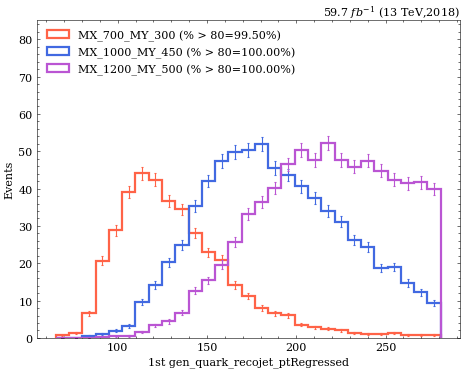

In [25]:
cut=80
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ptRegressed[:,0]']
)

100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


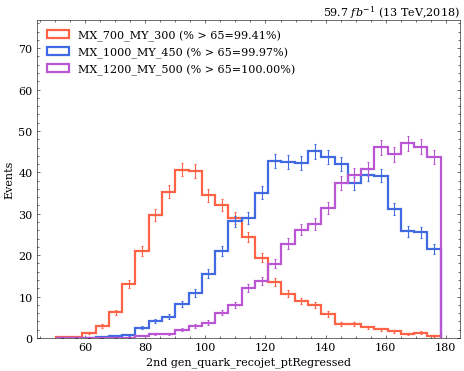

In [26]:
cut=65
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ptRegressed[:,1]']
)

100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


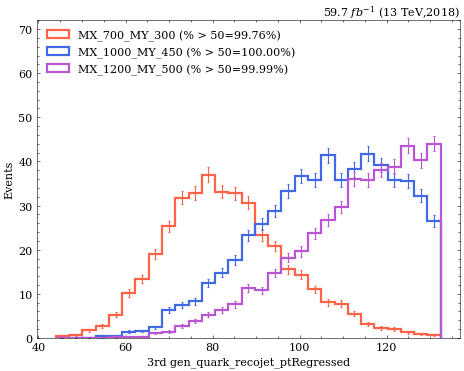

In [27]:
cut=50
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ptRegressed[:,2]']
)

100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


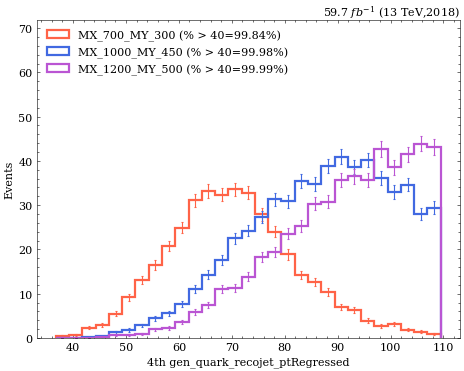

In [28]:
cut=40
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ptRegressed[:,3]']
)

100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


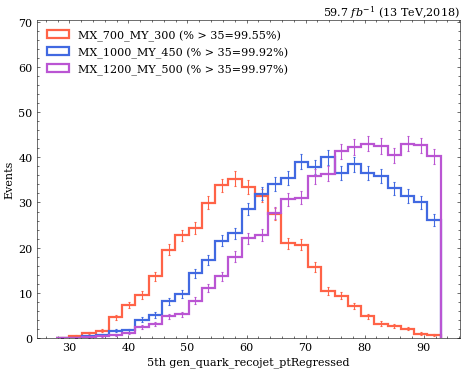

In [29]:
cut=35
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ptRegressed[:,4]']
)

100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


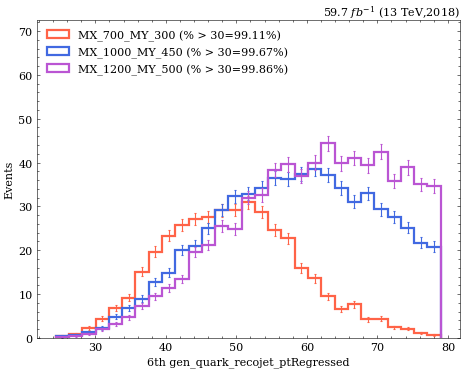

In [30]:
cut=30
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ptRegressed[:,5]']
)

100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


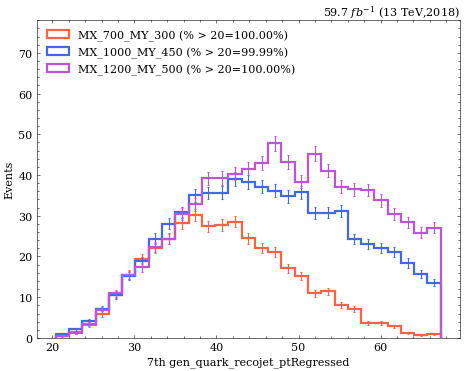

In [31]:
cut=20
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ptRegressed[:,6]']
)

100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


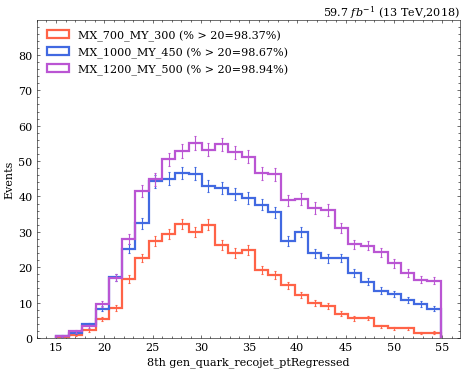

In [32]:
cut=20
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ptRegressed[:,7]']
)

In [33]:
t8btag_jets = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)

In [34]:
def selection_purity(t):
    sigId = t.jet_signalId
    n_sig = ak.sum(sigId>-1,axis=-1)
    return ak.mean(n_sig/8)

signal = signal.apply(t8btag_jets)
print(signal.apply(selection_purity).npy)

[0.77059483 0.79825725 0.81612749]


In [35]:
t8btag_pt20 = EventFilter('t8btag_pt20', filter=lambda t: ak.sum(t.jet_ptRegressed>20,axis=-1) >= 8)

In [36]:
signal = yieldinfo(signal, t8btag_pt20)
print(signal.apply(selection_purity).npy)

[0.94958549 0.95929162 0.96333844]
[0.77245244 0.79984918 0.81777573]


In [37]:
t8btag_pt30 = EventFilter('t8btag_pt30', filter=lambda t: ak.sum(t.jet_ptRegressed>30,axis=-1) >= 6)

In [38]:
signal = yieldinfo(signal, t8btag_pt30)
print(signal.apply(selection_purity).npy)

[0.97865108 0.98905829 0.99357772]
[0.77392926 0.80078951 0.81839981]


In [39]:
t8btag_pt35 = EventFilter('t8btag_pt35', filter=lambda t: ak.sum(t.jet_ptRegressed>35,axis=-1) >= 5)

In [40]:
signal = yieldinfo(signal, t8btag_pt35)
print(signal.apply(selection_purity).npy)

[0.99415278 0.99800765 0.99889604]
[0.77428365 0.80096314 0.81852346]


In [41]:
t8btag_pt40 = EventFilter('t8btag_pt40', filter=lambda t: ak.sum(t.jet_ptRegressed>40,axis=-1) >= 4)

In [42]:
signal = yieldinfo(signal, t8btag_pt40)
print(signal.apply(selection_purity).npy)

[0.99879352 0.99966728 0.99995195]
[0.77434759 0.80098667 0.81853476]


In [43]:
t8btag_pt50 = EventFilter('t8btag_pt50', filter=lambda t: ak.sum(t.jet_ptRegressed>50,axis=-1) >= 3)

In [44]:
signal = yieldinfo(signal, t8btag_pt50)
print(signal.apply(selection_purity).npy)

[0.9978861  0.99977227 0.99990389]
[0.77445906 0.80100485 0.81854735]


In [45]:
t8btag_pt65 = EventFilter('t8btag_pt65', filter=lambda t: ak.sum(t.jet_ptRegressed>65,axis=-1) >= 2)

In [46]:
signal = yieldinfo(signal, t8btag_pt65)
print(signal.apply(selection_purity).npy)

[0.99533453 0.9997547  0.99995194]
[0.77448819 0.80101737 0.81855265]


In [47]:
t8btag_pt80 = EventFilter('t8btag_pt80', filter=lambda t: ak.sum(t.jet_ptRegressed>80,axis=-1) >= 1)

In [48]:
signal = yieldinfo(signal, t8btag_pt80)
print(signal.apply(selection_purity).npy)

[0.99703557 0.99989485 0.99996796]
[0.77440535 0.80102931 0.81855284]


In [49]:
signal.apply(lambda t:t.extend(gen_quark_recojet_ordered_btag=ak.sort(t.gen_quark_recojet_btag, axis=-1, ascending=False)))

[None, None, None]

100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


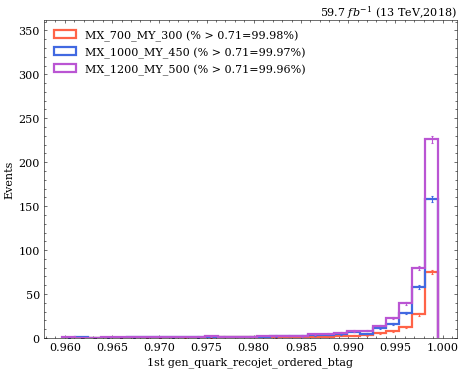

In [50]:
cut=jet_btagWP[3]
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ordered_btag[:,0]']
)

100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


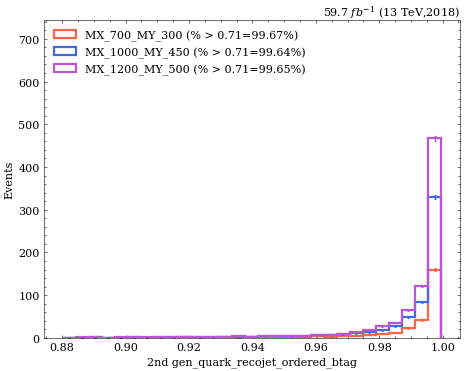

In [51]:
cut=jet_btagWP[3]
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ordered_btag[:,1]']
)

100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


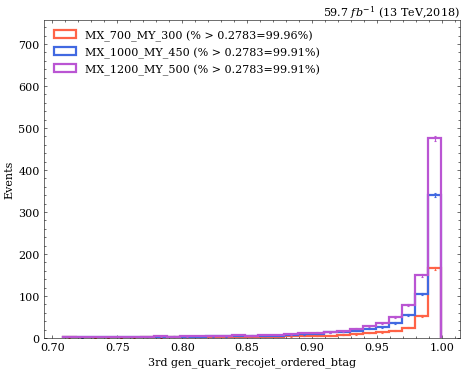

In [52]:
cut=jet_btagWP[2]
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ordered_btag[:,2]']
)

100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


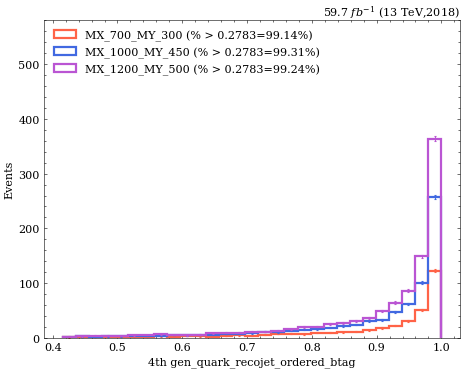

In [53]:
cut=jet_btagWP[2]
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ordered_btag[:,3]']
)

100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


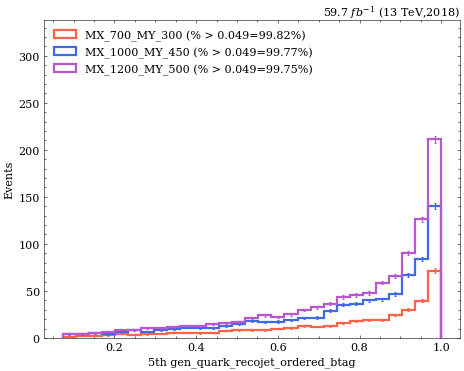

In [54]:
cut=jet_btagWP[1]
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ordered_btag[:,4]']
)

100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


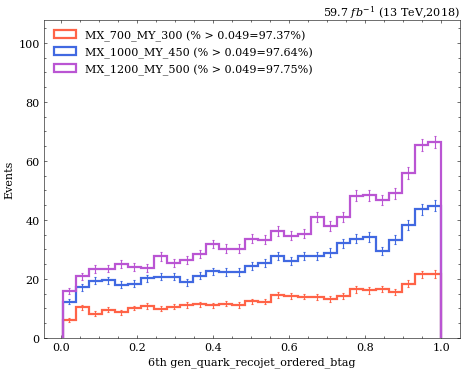

In [55]:
cut=jet_btagWP[1]
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ordered_btag[:,5]']
)

100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


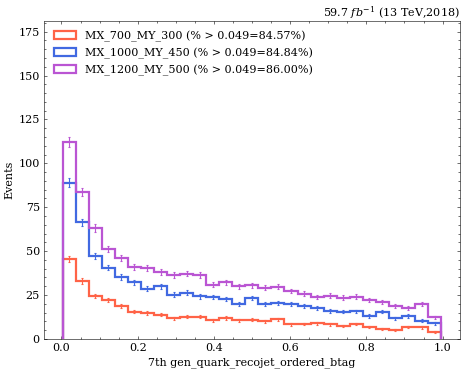

In [56]:
cut=jet_btagWP[1]
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ordered_btag[:,6]']
)

100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


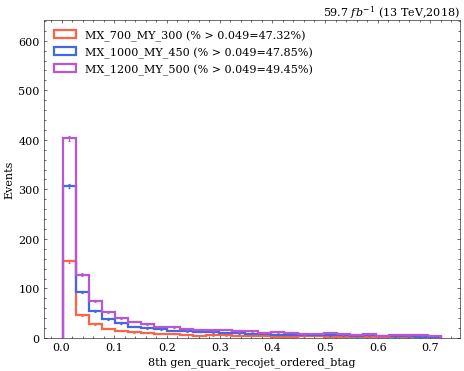

In [57]:
cut=jet_btagWP[1]
study.quick(
    signal, legend=True,
    masks=good_gen_quarks,
    h_label_stat=lambda h: f"% > {cut}={ak.mean(h.array>cut):0.2%}",
    varlist=['gen_quark_recojet_ordered_btag[:,7]']
)

In [58]:
t8btag_loose_btag = EventFilter('t8btag_loose_btag', filter=lambda t:ak.sum(t.jet_btag>jet_btagWP[1], axis=-1) >= 5)

In [59]:
signal = yieldinfo(signal, t8btag_loose_btag)
print(signal.apply(selection_purity).npy)

[0.96691317 0.97880918 0.98381903]
[0.77942259 0.80411727 0.82093626]


In [60]:
t8btag_medium_btag = EventFilter('t8btag_medium_btag', filter=lambda t:ak.sum(t.jet_btag>jet_btagWP[2], axis=-1) >= 4)

In [61]:
signal = yieldinfo(signal, t8btag_medium_btag)
print(signal.apply(selection_purity).npy)

[0.97024889 0.976309   0.98063802]
[0.78229542 0.80618707 0.82262953]


In [62]:
t8btag_tight_btag = EventFilter('t8btag_tight_btag', filter=lambda t:ak.sum(t.jet_btag>jet_btagWP[3], axis=-1) >= 2)

In [63]:
signal = yieldinfo(signal, t8btag_tight_btag)
print(signal.apply(selection_purity).npy)

[0.99450118 0.99521285 0.99536699]
[0.78251484 0.80644812 0.82286123]


In [64]:
yields = np.stack(yieldinfo.yields).T

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

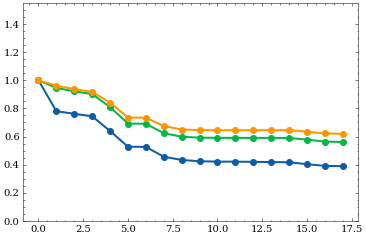

In [65]:
graph_arrays( np.arange(yields.shape[1]), yields/yields[:,:1] )

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


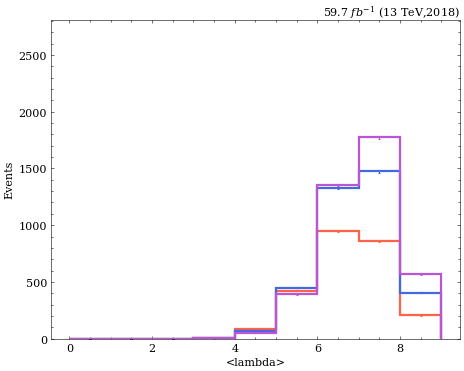

In [68]:
study.quick( 
    signal,
    varlist=[lambda t:ak.sum(t.jet_signalId>-1,axis=-1)]
)

In [66]:
# from utils.eightbUtils.selecting import selected_jet_btagwp, selected_jet_ptregressed

In [67]:
# yieldinfo(signal, selected_jet_btagwp())